# Variational Bayes under model misspecification

This notebook explores the performance of variational inference (VI; syn. variational Bayes) under model misspecification, as described in
>**Wang, Y. & Blei, D. M. Variational Bayes under Model Misspeciﬁcation. 2020. https://arxiv.org/abs/1905.10859.**

This code implements the model misspecification scenario described in section *C.2 Component misspecification in Bayesian mixture models* from the appendix of this paper:
>"Suppose the data is generated by a Bayesian mixture model where each component is Gaussian and shares the same variance. But we fit a Bayesian mixture model where each component is a t-distribution."

Following the methods in this paper, two algorithms are used to estimate model parameters: automatic differentiation variational inference (ADVI) for VI and No-U-Turn sampler (NUTS) for Hamiltonian Monte Carlo.

We reproduce part of Figure 2 for this setting and also provide empirical evidence for Theorem 2.

Jacqueline Maasch and Matthew T. Ford | April 2023

## Preamble

In [1]:
# General importations.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import time
from scipy import stats
import warnings

# Stan-related importations.
import cmdstanpy
from cmdstanpy import CmdStanModel
import arviz as az
import nest_asyncio # https://pystan.readthedocs.io/en/latest/faq.html
nest_asyncio.apply()

# View versioning.
print("python version     :", platform.python_version())
print("numpy version      :", np.__version__)
print("pandas version     :", pd.__version__)
print("matplotlib version :", matplotlib.__version__)
print("seaborn version    :", sns.__version__)
print("cmdstanpy version  :", cmdstanpy.__version__)

python version     : 3.8.10
numpy version      : 1.22.4
pandas version     : 1.3.1
matplotlib version : 3.3.4
seaborn version    : 0.12.2
cmdstanpy version  : 1.1.0


C:\Users\fordm\anaconda3\envs\new\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# For cmdstanpy progress bars.
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [3]:
'''
Must also install cmdstan.
If this produces an SSL certificate verification errorr, locate the file 
"Install Certificates.command" and double click to run this script first.
https://stackoverflow.com/questions/52805115/certificate-verify-failed-unable-to-get-local-issuer-certificate
'''
#from cmdstanpy import install_cmdstan
#install_cmdstan(verbose = True)

'\nMust also install cmdstan.\nIf this produces an SSL certificate verification errorr, locate the file \n"Install Certificates.command" and double click to run this script first.\nhttps://stackoverflow.com/questions/52805115/certificate-verify-failed-unable-to-get-local-issuer-certificate\n'

## Generate data from a mixture of Gaussians

Under the true generating process, data are sampled from a mixture of two Gaussians with equal variance.

In [4]:
stan_folder = "./"
stan_file = stan_folder + "mixture_model_misspecified.stan"
with open(stan_file) as file:
    misspecified_model = file.read()
misspecified_model_compiled = CmdStanModel(stan_file = "mixture_model_misspecified.stan")

# Total samples.
ns = [20,100,500,2500,10000]
tv_true_exacts = []
tv_vi_exacts = [] 
true_exact_vals = []
vi_exact_vals = []
vi_nlls = []
exact_nlls = []


mu = np.array([1.25, 4.75])
sigma = np.array([1.5])
p = 0.5

for n in ns:
    
    # generate training data of size n
    mixture_id = stats.bernoulli.rvs(p, size = n)
    y_true = stats.norm.rvs(loc = mu[mixture_id], scale = sigma, size = n)
    df = pd.DataFrame({"Component ID": mixture_id, 
                       "Observed": y_true})
    df["Component mean"] = df["Component ID"].map(lambda x: mu[x])
    
    # Place data in dictionary for Stan models.
    stan_data = {"N": df.shape[0], 
                 "y": df["Observed"].values}

    # Filter warnings?
    warnings_setting = "ignore" # "once"

    # Sampling parameters.
    n_fit = 100
    n_warmup = 500
    n_chains = 2

    
    
    # Fit misspecified model with MCMC.
    start = time.time()
    misspecified_model_fit_hmc = misspecified_model_compiled.sample(data = stan_data, 
                                                                    chains = n_chains, 
                                                                    iter_warmup = n_warmup, 
                                                                    iter_sampling = n_fit)
    print("HMC-NUTS complete in {} seconds.".format(round(time.time() - start, 3)))
    misspecified_model_summary_hmc = az.summary(misspecified_model_fit_hmc)
    
    # Fit misspecified model with VI.
    misspecified_model_fit_advi = misspecified_model_compiled.variational(data = stan_data, 
                                                                output_samples = n_fit, 
                                                                algorithm = "meanfield", 
                                                                iter = 1000,
                                                                grad_samples = 20)
    print("Variational inference complete in {} seconds.".format(round(time.time() - start, 3)))
    misspecified_model_hmc_ppc_data = az.from_cmdstanpy(posterior = misspecified_model_fit_hmc,
                                                        posterior_predictive = ["y_posterior_pred"], 
                                                        observed_data = {"y": df["Observed"].values})

    
    # define functions used for evaluating TV error ratio and NLL
    def t_mixture_pdf(y, theta, nu, mu1, mu2, sigma):
        t_dist1 = stats.t(df=nu, loc=mu1, scale=sigma)
        t_dist2 = stats.t(df=nu, loc=mu2, scale=sigma)
        return theta*t_dist1.pdf(y) + (1-theta)*t_dist2.pdf(y) 

    def get_avg_pdf_misspecified_advi(y, sample_pd):
        'calculates pdf at y for each set of variational parameters of misspecified model sampled and then averages'
        n = len(sample_pd)
        pdf = 0
        for i in range(n):
            row = sample_pd.iloc[i]
            pdf += t_mixture_pdf(y, row['theta'], row['nu'], row['mu[1]'], row['mu[2]'], row['sigma'])/n
        return pdf

    def normal_mixture_pdf(y, theta, mu1, mu2, sigma):
        normal_dist1 = stats.norm(loc=mu1, scale=sigma)
        normal_dist2 = stats.norm(loc=mu2, scale=sigma)
        return theta*normal_dist1.pdf(y) + (1-theta)*normal_dist2.pdf(y) 

    def get_avg_pdf_correct_hmc(y, stan_variables):
        'calculates pdf at y for each set of MCMC parameters of correct model sampled (past warmup) and then averages'
        n = len(stan_variables['mu'])
        pdf = 0
        for i in range(n):
            mu1 = stan_variables['mu'][i][0]
            mu2 = stan_variables['mu'][i][1]
            theta = stan_variables['theta'][i]
            sigma = stan_variables['sigma'][i]
            pdf += normal_mixture_pdf(y, theta, mu1, mu2, sigma)/n
        return pdf

    def get_avg_pdf_misspecified_hmc(y, stan_variables):
        'calculates pdf at y for each set of MCMC parameters of misspecified model sampled (past warmup) and then averages'
        n = len(stan_variables['mu'])
        pdf = 0
        for i in range(n):
            mu1 = stan_variables['mu'][i][0]
            mu2 = stan_variables['mu'][i][1]
            theta = stan_variables['theta'][i]
            sigma = stan_variables['sigma'][i]
            nu = stan_variables['nu'][i]
            pdf += t_mixture_pdf(y, theta, nu, mu1, mu2, sigma)/n
        return pdf

    def true_pdf(y):
        'calculates pdf at y for each of 100 sets of parameters sampled from true model and then averages'
        m = 100
        sigma_dist = stats.norm(loc=2,scale=2)
        mu1_dist = stats.norm(loc=1,scale=1)
        mu2_dist = stats.norm(loc=5,scale=1)
        theta_dist = stats.beta(1,1)

        sigma = sigma_dist.rvs(m)
        mu1 = mu1_dist.rvs(m)
        mu2 = mu2_dist.rvs(m)
        theta = theta_dist.rvs(m)

        pdf = 0
        non_nans = 0
        for i in range(m):
            #print(f"sigma[{i}] = {sigma[i]}, mu1[{i}] = {mu1[i]}, mu2[{i}] = {mu2[i]}, theta[{i}] = {theta[i]}")
            this_pdf = normal_mixture_pdf(y, theta[i], mu1[i], mu2[i], sigma[i])
            #print(f"this_pdf[{i}] = {this_pdf}")
            if not (np.isnan(this_pdf) or this_pdf < .0000000000000000000001):
                non_nans += 1
                pdf += this_pdf

        return pdf / non_nans

    def tv(exact_fun, vi_fun, data):
        '''calculates pdfs at different values for true, MCMC misspecified, and VI misspecified to estimate
        VI_error/misspecification_error'''
        m = 100
        lower = min(data)
        upper = max(data)
        step = (upper - lower)/m
        val = lower
        true_exact_val = val
        vi_exact_val = val
        tv_true_exact = 0
        tv_vi_exact = 0
        while val <= upper:
            p_true = true_pdf(val)
            p_exact = exact_fun(val)
            p_vi = vi_fun(val)

            diff_true_exact = np.abs(p_true-p_exact)
            diff_vi_exact = np.abs(p_vi-p_exact)

            '''
            if diff_true_exact>tv_true_exact:
                tv_true_exact = diff_true_exact
                true_exact_val = val
            if diff_vi_exact>tv_vi_exact:
                tv_vi_exact = diff_vi_exact
                vi_exact_val = val
            '''

            tv_true_exact += .5*diff_true_exact
            tv_vi_exact += .5*diff_vi_exact
            val += step

        return tv_true_exact, tv_vi_exact, true_exact_val, vi_exact_val

    exact_fun = lambda y: get_avg_pdf_misspecified_hmc(y,misspecified_model_fit_hmc.stan_variables() )
    vi_fun = lambda y: get_avg_pdf_misspecified_advi(y,misspecified_model_fit_advi.variational_sample_pd)

    
    
    # Evaluate TV error ratio and NLLs
    tv_true_exact, tv_vi_exact, true_exact_val, vi_exact_val = tv(exact_fun,vi_fun, stan_data['y'])

    vi_nll = -misspecified_model_fit_advi.variational_sample_pd.log_p__.mean()/n
    exact_nll = -((misspecified_model_hmc_ppc_data.sample_stats['lp'].mean())/n).item()
    
    tv_true_exacts.append(tv_true_exact)
    tv_vi_exacts.append(tv_vi_exact)
    true_exact_vals.append(true_exact_val)
    vi_exact_vals.append(vi_exact_val)
    vi_nlls.append(vi_nll)
    exact_nlls.append(exact_nll)

    print('for ' + str(n) + ' data points')
    print('misspecification error: ', tv_true_exact)
    print('variational error: ', tv_vi_exact)
    print('VI mean NLL: ', vi_nll)
    print('exact mean NLL: ', exact_nll)
    print('')

08:57:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status
chain 1 |██████▎   | 00:00 Iteration: 300 / 600 [ 50%]  (Warmup)
chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   


08:57:25 - cmdstanpy - INFO - CmdStan done processing.
08:57:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'C:/Users/fordm/bayesian_analysis_orie6217/mixture_model_misspecified.stan', line 33, column 8 to line 35, column 67)
Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'C:/Users/fordm/bayesian_analysis_orie6217/mixture_model_misspecified.stan', line 33, column 8 to line 35, column 67)
Consider re-running with show_console=True if the above output is unclear!



HMC-NUTS complete in 0.199 seconds.


08:57:25 - cmdstanpy - INFO - Chain [1] start processing
08:57:26 - cmdstanpy - INFO - Chain [1] done processing


Variational inference complete in 0.959 seconds.


08:58:21 - cmdstanpy - INFO - CmdStan start processing


for 20 data points
misspecification error:  1.7434238519656216
variational error:  0.1784946609840179
VI mean NLL:  2.6291323999999996
exact mean NLL:  2.48957805



chain 1 |          | 00:00 Status
chain 2 |          | 00:00 Status
chain 1 |██▌       | 00:00 Iteration:   1 / 600 [  0%]  (Warmup)
chain 1 |█████     | 00:00 Iteration: 200 / 600 [ 33%]  (Warmup)
chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   


08:58:22 - cmdstanpy - INFO - CmdStan done processing.
08:58:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'C:/Users/fordm/bayesian_analysis_orie6217/mixture_model_misspecified.stan', line 33, column 8 to line 35, column 67)
Consider re-running with show_console=True if the above output is unclear!



HMC-NUTS complete in 0.556 seconds.


C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

Variational inference complete in 2.581 seconds.


08:59:19 - cmdstanpy - INFO - CmdStan start processing


for 100 data points
misspecification error:  1.32608257259694
variational error:  0.11888172255356105
VI mean NLL:  2.3154024
exact mean NLL:  2.28060915



chain 1 |          | 00:00 Status
chain 2 |          | 00:00 Status
chain 1 |██▌       | 00:01 Iteration:   1 / 600 [  0%]  (Warmup)
chain 2 |███▊      | 00:01 Iteration: 100 / 600 [ 16%]  (Warmup)
chain 1 |███▊      | 00:02 Iteration: 100 / 600 [ 16%]  (Warmup)
chain 2 |██████▎   | 00:02 Iteration: 300 / 600 [ 50%]  (Warmup)
chain 1 |█████     | 00:03 Iteration: 200 / 600 [ 33%]  (Warmup)
chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     


08:59:25 - cmdstanpy - INFO - CmdStan done processing.
08:59:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'C:/Users/fordm/bayesian_analysis_orie6217/mixture_model_misspecified.stan', line 33, column 8 to line 35, column 67)
	Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'C:/Users/fordm/bayesian_analysis_orie6217/mixture_model_misspecified.stan', line 33, column 8 to line 35, column 67)
	Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'C:/Users/fordm/bayesian_analysis_orie6217/mixture_model_misspecified.stan', line 33, column 8 to line 35, column 67)
Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'C:/Users/fordm/bayesian_analysis_orie6217/mixture_model_misspecified.stan', line 33, column 8 to line 35, column 67)
Consider re-running with show_console=True if the above output is un


HMC-NUTS complete in 5.306 seconds.


C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

Variational inference complete in 15.589 seconds.


09:00:30 - cmdstanpy - INFO - CmdStan start processing


for 500 data points
misspecification error:  1.2233853760658364
variational error:  0.10672311036210165
VI mean NLL:  2.2701712000000005
exact mean NLL:  2.2626502



chain 1 |          | 00:00 Status
chain 1 |██▌       | 00:08 Iteration:   1 / 600 [  0%]  (Warmup)
chain 1 |███▊      | 00:11 Iteration: 100 / 600 [ 16%]  (Warmup)
chain 1 |█████     | 00:15 Iteration: 200 / 600 [ 33%]  (Warmup)
chain 1 |██████▎   | 00:18 Iteration: 300 / 600 [ 50%]  (Warmup)
chain 1 |███████▌  | 00:21 Iteration: 400 / 600 [ 66%]  (Warmup)
chain 1 |██████████| 00:24 Iteration: 501 / 600 [ 83%]  (Sampling)A
chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:25 Sampling completed                     


09:00:56 - cmdstanpy - INFO - CmdStan done processing.
09:00:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'C:/Users/fordm/bayesian_analysis_orie6217/mixture_model_misspecified.stan', line 33, column 8 to line 35, column 67)
	Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'C:/Users/fordm/bayesian_analysis_orie6217/mixture_model_misspecified.stan', line 33, column 8 to line 35, column 67)
	Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'C:/Users/fordm/bayesian_analysis_orie6217/mixture_model_misspecified.stan', line 33, column 8 to line 35, column 67)
	Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'C:/Users/fordm/bayesian_analysis_orie6217/mixture_model_misspecified.stan', line 33, column 8 to line 35, column 67)
	Exception: student_t_lpdf: Scale parameter is inf, but must be pos


HMC-NUTS complete in 25.768 seconds.


C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

Variational inference complete in 85.052 seconds.


09:02:50 - cmdstanpy - INFO - CmdStan start processing


for 2500 data points
misspecification error:  1.155793093636117
variational error:  0.07058999700946246
VI mean NLL:  2.2439484000000003
exact mean NLL:  2.23668812



chain 1 |          | 00:00 Status
chain 2 |          | 00:00 Status
chain 1 |█▎        | 00:00 Status
chain 1 |██▌       | 00:46 Iteration:   1 / 600 [  0%]  (Warmup)
chain 1 |███▊      | 01:04 Iteration: 100 / 600 [ 16%]  (Warmup)
chain 1 |█████     | 01:18 Iteration: 200 / 600 [ 33%]  (Warmup)
chain 1 |██████▎   | 01:31 Iteration: 300 / 600 [ 50%]  (Warmup)
chain 1 |███████▌  | 01:46 Iteration: 400 / 600 [ 66%]  (Warmup)
chain 1 |██████████| 01:59 Sampling completed                     
chain 2 |██████████| 01:59 Sampling completed                     


09:04:49 - cmdstanpy - INFO - CmdStan done processing.
09:04:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'C:/Users/fordm/bayesian_analysis_orie6217/mixture_model_misspecified.stan', line 33, column 8 to line 35, column 67)
	Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'C:/Users/fordm/bayesian_analysis_orie6217/mixture_model_misspecified.stan', line 33, column 8 to line 35, column 67)
	Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'C:/Users/fordm/bayesian_analysis_orie6217/mixture_model_misspecified.stan', line 33, column 8 to line 35, column 67)
	Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in 'C:/Users/fordm/bayesian_analysis_orie6217/mixture_model_misspecified.stan', line 33, column 8 to line 35, column 67)
	Exception: student_t_lpdf: Scale parameter is 0, but must be posit


HMC-NUTS complete in 119.774 seconds.


C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\fordm\anaconda3\envs\new\lib\site-packages\arviz\stats\diagnostics.py:561: 

Variational inference complete in 804.609 seconds.
for 10000 data points
misspecification error:  1.0497328509800496
variational error:  0.054940738325151055
VI mean NLL:  2.2335127999999993
exact mean NLL:  2.2334774500000005



In [5]:
print(tv_true_exacts)
print(tv_vi_exacts)
print(true_exact_vals)
print(vi_exact_vals)
print(vi_nlls)
print(exact_nlls)

[1.7434238519656216, 1.32608257259694, 1.2233853760658364, 1.155793093636117, 1.0497328509800496]
[0.1784946609840179, 0.11888172255356105, 0.10672311036210165, 0.07058999700946246, 0.054940738325151055]
[-1.3826257572785714, -3.0907230314385554, -2.4794561978169543, -4.608626364139533, -5.313249963538924]
[-1.3826257572785714, -3.0907230314385554, -2.4794561978169543, -4.608626364139533, -5.313249963538924]
[2.6291323999999996, 2.3154024, 2.2701712000000005, 2.2439484000000003, 2.2335127999999993]
[2.48957805, 2.28060915, 2.2626502, 2.23668812, 2.2334774500000005]


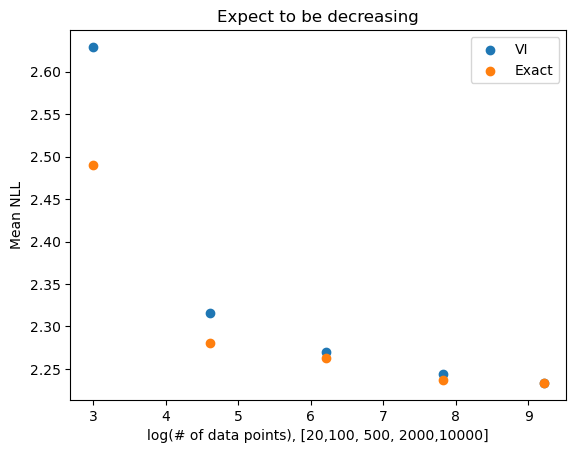

In [6]:
x = np.log(np.array(ns))
y1 = np.array(vi_nlls)

y2 = np.array(exact_nlls)

# Create the plot
fig, ax = plt.subplots()
ax.scatter(x, y1, label='VI')
ax.scatter(x, y2, label='Exact')

# Set the title and axis labels
ax.set_title("Expect to be decreasing")
ax.set_xlabel("log(# of data points), [20,100, 500, 2000,10000]")
ax.set_ylabel("Mean NLL")

# Set the legend
ax.legend()

# Display the plot
plt.show()


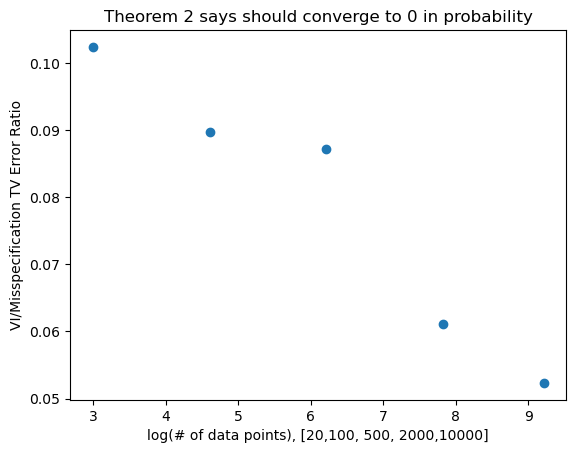

In [8]:
x = np.log(np.array(ns))
y1 = np.array(tv_vi_exacts)

y2 = np.array(tv_true_exacts)

# Create the plot
fig, ax = plt.subplots()
#ax.scatter(x, y1, label='Variational')
ax.scatter(x, y1/y2) #label='Misspecification')

# Set the title and axis labels
ax.set_title("Theorem 2 says should converge to 0 in probability")
ax.set_xlabel("log(# of data points), [20,100, 500, 2000,10000]")
ax.set_ylabel("VI/Misspecification TV Error Ratio")

# Set the legend
#ax.legend()

# Display the plot
plt.show()
